We employed GRPO (Group Relative Policy Optimization) as our core alignment algorithm. To adapt the training to the Kaggle TPU v3-8 environment without sacrificing performance, we implemented a "Lightweight" configuration.

Key Configuration (The "Efficiency" Build): 

Model: `google/gemma-3-1b-it`

LoRA Rank: `32 (Reduced from 64 to save memory)`

LoRA Alpha: `32.0(Reduced from 64.0 to save memory)`

Batch Size: `2 (Reduced from 4 to prevent OOM)`

Learning Rate: `3e-6`

Optimizer: `AdamW`

Framework: `JAX / Tunix / Flax`

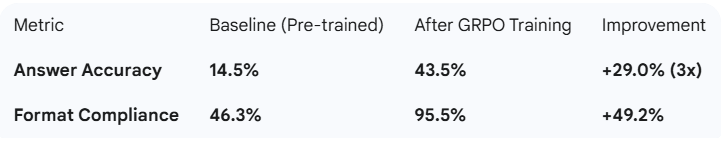

This experiment proves that Gemma 3 (1B) is a highly capable candidate for on-device reasoning tasks when aligned properly. Tunix provided a robust framework for GRPO, and by carefully managing TPU resources, we were able to unlock significant performance gains even with limited compute budgets.

## GRPO Demo

This tutorial demonstrates training the [Gemma](https://deepmind.google/models/gemma/)
3 1B-IT model on the [GSM8K math reasoning benchmark](https://huggingface.co/datasets/openai/gsm8k)
using [Group Relative Policy Optimization (GRPO)](https://arxiv.org/pdf/2402.03300).
GRPO can enhance your model's problem-solving skills on mathematical word problems,
coding problems, etc.

GRPO is an RL algorithm designed to enhance the reasoning abilities of LLMs. It
is a variant of [Proximal Policy Optimization (PPO)](https://arxiv.org/abs/1707.06347)
that reduces memory usage by eliminating the need for a separate value function
model. GRPO works by generating multiple responses for a given prompt,
evaluating these responses using a reward model, and then calculating a relative
advantage based on the group's performance to update the policy.

In this tutorial we use a `v5e-8` TPU for Gemma3-1b-it. Let's get started!

Note that the setup below is for the Gemma3-1B-IT model only. If you want to use
another model (say, Qwen2.5), you may need to change the setup (for example,
tokenizer, chat template, reward function, etc.).

In [ ]:
import os
os.environ["HF_HUB_DISABLE_XET"] = "1"

## Install necessary libraries

In [ ]:
!pip install -q kagglehub

!pip install -q ipywidgets

!pip install -q tensorflow
!pip install -q tensorflow_datasets
!pip install -q tensorboardX
!pip install -q transformers
!pip install -q grain
!pip install "google-tunix[prod]==0.1.3"

# !pip install -q git+https://github.com/google/tunix
# !pip install -q git+https://github.com/google/qwix

!pip uninstall -q -y flax
# !pip install -q git+https://github.com/google/flax.git
!pip install -U flax


!pip install -q datasets wandb

In [ ]:
import wandb, os
from kaggle_secrets import UserSecretsClient
# os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("WANDB_API_KEY")

## Imports

In [ ]:
import functools
import gc
import os
from pprint import pprint
import re

import csv
import shutil

from flax import nnx
import grain
import humanize
import jax
import jax.numpy as jnp
import kagglehub
import optax
from orbax import checkpoint as ocp
from pathlib import Path
import qwix
import tensorflow_datasets as tfds
from tqdm.auto import tqdm
from tunix.generate import sampler as sampler_lib
from tunix.generate import tokenizer_adapter as tokenizer_lib
# from tunix.models.gemma3 import model as gemma_lib
# from tunix.models.gemma3 import params as params_lib
from tunix.models.gemma3 import params
from tunix.models.gemma3 import model
from tunix.rl import rl_cluster as rl_cluster_lib
from tunix.rl.grpo.grpo_learner import GRPOConfig, GRPOLearner
from tunix.rl.rollout import base_rollout
from tunix.sft import metrics_logger
from datasets import load_dataset

## Hyperparameters

Let's define the configuration we are going to use. Note that this is by no
means a "perfect" set of hyperparameters. To get good results, you might have
to train the model for longer.

In [ ]:
# ====== Data ======
TRAIN_DATA_DIR = "./data/train"
TEST_DATA_DIR = "./data/test"
TRAIN_FRACTION = 1.0

# ====== LoRA ======
# RANK = 64 (origional setting)
# ALPHA = 64.0 (origional setting)

RANK = 32
ALPHA = 32.0

# ====== Sharding ======
MESH = [(1, 4), ("fsdp", "tp")]

# ====== GRPO ======
# === Generation during GRPO training ===
MAX_PROMPT_LENGTH = 256
TOTAL_GENERATION_STEPS = 512
# Important to keep a high-ish temperature for varied, diverse responses during
# training.
TEMPERATURE = 0.9
TOP_P = 1.0
TOP_K = 50
# The number of times the policy generates multiple responses for a given prompt
# within a single training step. This corresponds to `G` in Algorithm 1 in the
# paper. The "group" in GRPO comes from here.
NUM_GENERATIONS = 4

# === other GRPO configs ===
# The number of iterations per batch (𝜇 in GRPO algo 1).
NUM_ITERATIONS = 1
# The coefficient for the KL divergence penalty (𝛽) in the GRPO loss function.
# Important to keep a high enough value for this, otherwise, the KL divergence
# can increase unchecked.
BETA = 0.08
# Epsilon value for clipping (𝜀 in GRPO loss in paper). Similar to PPO, for
# stable updates.
EPSILON = 0.2

# ====== Training ======
# TRAIN_MICRO_BATCH_SIZE = 4 (origional setting)
TRAIN_MICRO_BATCH_SIZE = 2
# Increase `NUM_BATCHES` and `MAX_STEPS` for better results.
NUM_BATCHES = 3738
# Keep `NUM_TEST_BATCHES` low so that evaluation runs quickly. It can be
# increased to a max. of 330 (if batch size is 4).
NUM_TEST_BATCHES = 100

EVAL_EVERY_N_STEPS = 10  # this doesn't matter if `TRAIN_FRACTION = 1.0`.
NUM_EPOCHS = 1  # can potentially train for more epochs

# Number of training steps.
MAX_STEPS = int(NUM_BATCHES * NUM_ITERATIONS * TRAIN_FRACTION * NUM_EPOCHS)

# === AdamW, warmup, cosine scheduler ===
LEARNING_RATE = 3e-6
B1 = 0.9
B2 = 0.99
WEIGHT_DECAY = 0.1
# == Cosine decay with warmup scheduler ==
# Linearly increase learning rate from 0. to 5e-6 in the first 10% training
# steps, and then gradually decrease the learning rate to 0 using cosine
# scheduler.
WARMUP_STEPS = 0.1 * MAX_STEPS
# == Grad clipping ==
# Grad clipping to prevent large gradients. Found this
# important to keep KL divergence in check.
MAX_GRAD_NORM = 0.1

# Checkpoint saving
INTERMEDIATE_CKPT_DIR = "/tmp/content/intermediate_ckpt/"
CKPT_DIR = "/tmp/content/ckpts/"
SAVE_INTERVAL_STEPS = 500
MAX_TO_KEEP = 4

# ====== Inference ======
GENERATION_CONFIGS = {
    # greedy search
    "greedy": {"temperature": 1e-4, "top_k": 1, "top_p": 1.0},
    # some randomness
    "standard": {"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    # liberal
    "liberal": {"temperature": 0.85, "top_k": 2000, "top_p": 1.0},
}

## Utility functions

In [ ]:
def show_hbm_usage():
  """Displays memory usage per device."""
  fmt_size = functools.partial(humanize.naturalsize, binary=True)

  for d in jax.local_devices():
    stats = d.memory_stats()
    used = stats["bytes_in_use"]
    limit = stats["bytes_limit"]
    print(f"Using {fmt_size(used)} / {fmt_size(limit)} ({used/limit:%}) on {d}")

## Data preprocessing

First, let's define some special tokens. We instruct the model to first reason
between the `<reasoning>` and `</reasoning>` tokens. After
reasoning, we expect it to provide the answer between the `<answer>` and
`</answer>` tokens.

In [ ]:
reasoning_start = "<reasoning>"
reasoning_end = "</reasoning>"
solution_start = "<answer>"
solution_end = "</answer>"


SYSTEM_PROMPT = f"""You are given a problem. Think about the problem and \
provide your reasoning. Place it between {reasoning_start} and \
{reasoning_end}. Then, provide the final answer (i.e., just one numerical \
value) between {solution_start} and {solution_end}."""

TEMPLATE = """<start_of_turn>user
{system_prompt}

{question}<end_of_turn>
<start_of_turn>model"""

We use OpenAI's [GSM8K dataset](https://huggingface.co/datasets/openai/gsm8k), which comprises grade school math word problems.

In [ ]:
def extract_hash_answer(text: str) -> str | None:
  if "####" not in text:
    return None
  return text.split("####")[1].strip()


def _load_from_tfds(data_dir: str, split: str):
  import tensorflow_datasets.text.gsm8k
  return tfds.data_source(
      "gsm8k",
      split=split,
      data_dir=data_dir,
      builder_kwargs={"file_format": tfds.core.FileFormat.ARRAY_RECORD},
      download=True,
  )


def download_kaggle_dataset(target_dir="./data/gsm8k"):
  os.makedirs(target_dir, exist_ok=True)
  src = kagglehub.dataset_download("thedevastator/grade-school-math-8k-q-a")
  src = Path(src)
  dst = Path(target_dir)

  for csv_file in src.glob("*.csv"):  # match all CSV files
    shutil.copy2(csv_file, dst / csv_file.name)
    print(f"Copied {csv_file.name} → {dst/csv_file.name}")
  return target_dir


def get_dataset(data_dir, split="train", source="tfds") -> grain.MapDataset:
  # Download data
  if not os.path.exists(data_dir):
    os.makedirs(data_dir)

  if source == "tfds":
    import tensorflow_datasets.text.gsm8k
    data = tfds.data_source(
        "gsm8k",
        split=split,
        data_dir=data_dir,
        builder_kwargs={"file_format": tfds.core.FileFormat.ARRAY_RECORD},
        download=True,
    )

  elif source == "kaggle":
    kaggle_dir = download_kaggle_dataset(data_dir)
    file_name = "main_" + split + ".csv"
    csv_path = os.path.join(kaggle_dir, file_name)  # adjust filename if needed

    data = []
    with open(csv_path, newline="", encoding="utf-8") as csvfile:
      reader = csv.DictReader(csvfile)
      for row in reader:
        data.append({
            "question": row["question"],
            "answer": row["answer"],
        })

  elif source == "huggingface":    
    os.environ["HF_HUB_DISABLE_XET"] = "1"
    data = load_dataset("gsm8k", "main", split=split)
      
  else:
    raise ValueError(f"Unknown source: {source}")

  def _as_text(v):
    return v if isinstance(v, str) else v.decode("utf-8")

  dataset = (
      grain.MapDataset.source(data)
      .shuffle(seed=42)
      .map(
          lambda x: {
              # passed to model forward pass
              "prompts": TEMPLATE.format(
                  system_prompt=SYSTEM_PROMPT,
                  question=_as_text(x["question"]),
              ),
              # passed to reward functions
              "question": _as_text(x["question"]),
              # passed to reward functions
              "answer": extract_hash_answer(_as_text(x["answer"])),
          }
      )
  )
  return dataset

We split the dataset set into train and test sets as usual.

In [ ]:
# source = input("Choose data source [tfds/kaggle]: ").strip().lower()
source = "huggingface"

if source not in ("tfds", "kaggle", "huggingface"):
  print("Invalid choice. Defaulting to 'tfds'.")
  source = ""

print(f"Using data source: {source}")

dataset = get_dataset(TRAIN_DATA_DIR, "train", source).batch(TRAIN_MICRO_BATCH_SIZE)[
    :NUM_BATCHES
]

if TRAIN_FRACTION == 1.0:
  train_dataset = dataset.repeat(NUM_EPOCHS)
  val_dataset = None
else:
  train_dataset = dataset[: int(len(dataset) * TRAIN_FRACTION)]
  train_dataset = train_dataset.repeat(NUM_EPOCHS)

  val_dataset = dataset[int(len(dataset) * TRAIN_FRACTION) :].repeat(NUM_EPOCHS)

test_dataset = get_dataset(TEST_DATA_DIR, "test", source).batch(TRAIN_MICRO_BATCH_SIZE)[
    :NUM_TEST_BATCHES
]

dataset_lengths = (
    len(train_dataset),
    len(val_dataset) if val_dataset is not None else 0,
    len(test_dataset),
)
print(f"dataset contains {dataset_lengths} of batches")

Let's see how one batch of the training dataset looks like!


In [ ]:
for ele in train_dataset[:1]:
  pprint(ele)

## Load the policy model and the reference model

The policy model is the model which is actually trained and whose weights are
updated. The reference model is the model with which we compute KL divergence.
This is to ensure that the policy updates are not huge and that it does not
deviate too much from the reference model.

Typically, the reference model is the base model, and the policy model is the
same base model, but with LoRA parameters. Only the LoRA parameters are updated.

Note: We perform full precision (fp32) training. You can, however, leverage
Qwix for QAT.

To load the model, you need to be on [Kaggle](https://www.kaggle.com/) and need
to have agreed to the Gemma license
#[here](https://www.kaggle.com/models/google/gemma/flax/).

In [ ]:
#Vibe Coding with Gemini
#Inseet your KAGGLE_USERNAME & KAGGLE_KEY at Add-onsfunction
 
from kaggle_secrets import UserSecretsClient
import kagglehub

def auto_login():
    # 1. 先嘗試從 Kaggle 保險箱 (Secrets) 拿鑰匙
    try:
        user_secrets = UserSecretsClient()
        username = user_secrets.get_secret("KAGGLE_USERNAME")
        key = user_secrets.get_secret("KAGGLE_KEY")
        
        # 如果保險箱有東西，就設定到環境變數
        if username and key:
            os.environ["KAGGLE_USERNAME"] = username
            os.environ["KAGGLE_KEY"] = key
            print("✅ 已從 Secrets 自動取得權限，無需手動輸入！")
            return
    except Exception:
        # 如果保險箱沒設定或抓不到，就什麼都不做，進入下一步
        pass

    # 2. 檢查環境變數是否已經設定好了 (例如雲端環境可能自動注入)
    if "KAGGLE_USERNAME" in os.environ and "KAGGLE_KEY" in os.environ:
         print("✅ 環境變數已設定，跳過登入步驟。")
         return

    # 3. 如果以上都沒辦法，才叫出互動視窗請人輸入
    print("⚠️ 找不到自動登入資訊，啟動手動登入模式...")
    kagglehub.login()

# 執行自動登入函式
auto_login()

In [ ]:
# Log in
#if "KAGGLE_USERNAME" not in os.environ or "KAGGLE_KEY" not in os.environ:
#  kagglehub.login()

This code snippet serves as a workaround to re-save the pre-trained model checkpoint from Kaggle into a local format that is compatible with the [Flax NNX](https://flax.readthedocs.io/en/stable/why.html) library. Because the original checkpoint has parameter names and tensor structures that don't match the target NNX model architecture, it cannot be loaded directly.

We first load the original weights into a temporary model instance, then extract and re-save the model's state into a new, properly formatted local checkpoint, which can then be successfully loaded by the final sharded NNX model.

In [ ]:
!rm /tmp/content/intermediate_ckpt/* -rf

!rm /tmp/content/ckpts/* -rf

model_family = "gemma3"
if model_family == "gemma3":
  MODEL_CP_PATH = params.GEMMA3_1B_IT
  config = model.ModelConfig.gemma3_1b()
  gemma = params.create_model_from_checkpoint(MODEL_CP_PATH, config)
  tokenizer = params.create_tokenizer()

  checkpointer = ocp.StandardCheckpointer()
  _, state = nnx.split(gemma)
  checkpointer.save(os.path.join(INTERMEDIATE_CKPT_DIR, "state"), state)
  checkpointer.wait_until_finished()
  # Delete the intermediate model to save memory.
  del params
  del gemma
  del state
  gc.collect()

### Model Loading and LoRA Application

These two functions work together to load a base model from a checkpoint and apply a LoRA (Low-Rank Adaptation) layer to it.

* `get_ref_model`: Loads the complete Gemma model from a specified checkpoint path. It uses **JAX sharding** to distribute the model parameters across multiple devices.
* `get_lora_model`: Takes the base model and applies LoRA layers to it. It uses a `LoraProvider` to select specific layers (like attention and MLP layers) to be adapted. The resulting LoRA-infused model is then sharded and updated to ensure it's ready for distributed training.

In [ ]:
from tunix.models.gemma3 import params

def get_gemma_ref_model(ckpt_path):
  mesh = jax.make_mesh(*MESH)
  model_config = model.ModelConfig.gemma3_1b()
  abs_gemma: nnx.Module = nnx.eval_shape(
      lambda: params.create_model_from_checkpoint(MODEL_CP_PATH, config)
  )

  abs_state = nnx.state(abs_gemma)
  abs_state = jax.tree.map(
      lambda a, s: jax.ShapeDtypeStruct(a.shape, jnp.bfloat16, sharding=s),
      abs_state,
      nnx.get_named_sharding(abs_state, mesh),
  )
  checkpointer = ocp.StandardCheckpointer()
  restored_params = checkpointer.restore(ckpt_path, target=abs_state)

  graph_def, _ = nnx.split(abs_gemma)
  gemma = nnx.merge(graph_def, restored_params)
  return gemma, mesh, model_config


def get_lora_model(base_model, mesh):
  lora_provider = qwix.LoraProvider(
      module_path=(
          ".*q_einsum|.*kv_einsum|.*gate_proj|.*down_proj|.*up_proj|"
          ".*attn_vec_einsum"
      ),
      rank=RANK,
      alpha=ALPHA,
  )

  model_input = base_model.get_model_input()
  lora_model = qwix.apply_lora_to_model(
      base_model, lora_provider, **model_input
  )

  with mesh:
    state = nnx.state(lora_model)
    pspecs = nnx.get_partition_spec(state)
    sharded_state = jax.lax.with_sharding_constraint(state, pspecs)
    nnx.update(lora_model, sharded_state)

  return lora_model

Now we load reference and policy Gemma models using the Flax NNX library and display their structures.

In [ ]:
# Reference model
if model_family == "gemma3":
  ref_model, mesh, model_config = get_gemma_ref_model(
      ckpt_path=os.path.join(INTERMEDIATE_CKPT_DIR, "state")
  )

In [ ]:
# Policy model
lora_policy = get_lora_model(ref_model, mesh=mesh)
# nnx.display(lora_policy)

## Define reward functions

We define four reward functions:

- reward if the format of the output exactly matches the instruction given in
`TEMPLATE`;
- reward if the format of the output approximately matches the instruction given
in `TEMPLATE`;
- reward if the answer is correct/partially correct;
- Sometimes, the text between `<answer>`, `</answer>` might not be one
  number. So, we extract the number, and reward the model if the answer is correct.

The reward functions are inspired from
[here](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb).

First off, let's define a RegEx for checking whether the format matches.

In [ ]:
match_format = re.compile(
    rf"^[\s]{{0,}}"
    rf"{reasoning_start}.+?{reasoning_end}.*?"
    rf"{solution_start}(.+?){solution_end}"
    rf"[\s]{{0,}}$",
    flags=re.MULTILINE | re.DOTALL,
)

match_format.search(
    f"{reasoning_start}Let me"
    f" think!{reasoning_end}{solution_start}2{solution_end}",
)

Give the model a reward of 3 points if the format matches exactly.

In [ ]:
def match_format_exactly(prompts, completions, **kwargs):
  return [
      0 if match_format.search(response) is None else 3.0
      for response in completions
  ]

We also reward the model if the format of the output matches partially.

In [ ]:
def match_format_approximately(prompts, completions, **kwargs):
  scores = []

  for completion in completions:
    score = 0
    response = completion
    # Count how many keywords are seen - we penalize if too many!
    # If we see 1, then plus some points!
    score += 0.5 if response.count(reasoning_start) == 1 else -0.5
    score += 0.5 if response.count(reasoning_end) == 1 else -0.5
    score += 0.5 if response.count(solution_start) == 1 else -0.5
    score += 0.5 if response.count(solution_end) == 1 else -0.5
    scores.append(score)
  return scores

Reward the model if the answer is correct. A reward is also given if the answer
does not match exactly, i.e., based on how close the answer is to the correct
value.

In [ ]:
def check_answer(prompts, completions, answer, **kwargs):
  responses = completions

  extracted_responses = [
      guess.group(1) if (guess := match_format.search(r)) is not None else None
      for r in responses
  ]

  scores = []
  assert len(extracted_responses) == len(
      answer
  ), f"{extracted_responses} and {answer} have mismatching length"
  for guess, true_answer in zip(extracted_responses, answer):
    score = 0
    if guess is None:
      scores.append(0)
      continue
    # Correct answer gets 3 points!
    if guess == true_answer:
      score += 3.0
    # Match if spaces are seen
    elif guess.strip() == true_answer.strip():
      score += 1.5
    else:
      # We also reward it if the answer is close via ratios!
      # Ie if the answer is within some range, reward it!
      try:
        ratio = float(guess) / float(true_answer)
        if ratio >= 0.9 and ratio <= 1.1:
          score += 0.5
        elif ratio >= 0.8 and ratio <= 1.2:
          score += 0.25
        else:
          score -= 1.0  # Penalize wrong answers
      except:
        score -= 0.5  # Penalize
    scores.append(score)
  return scores

Sometimes, the text between `<answer>` and `</answer>` might not be one
number; it can be a sentence. So, we extract the number and compare the answer.

In [ ]:
match_numbers = re.compile(
    rf"{solution_start}.*?([\d\.]{{1,}})", flags=re.MULTILINE | re.DOTALL
)
match_numbers.findall(f"{solution_start}  0.34  {solution_end}")

In [ ]:
def check_numbers(prompts, completions, answer, **kwargs):
  question = kwargs["question"]
  responses = completions

  extracted_responses = [
      guess.group(1) if (guess := match_numbers.search(r)) is not None else None
      for r in responses
  ]

  scores = []
  print("START ============================")
  print(f"Question: {question[0]}")
  print(f"Answer: {answer[0]}")
  print(f"Response: {responses[0]}")
  print(f"Extracted: {extracted_responses[0]}")
  print("END ==============================")
  for guess, true_answer in zip(extracted_responses, answer):
    if guess is None:
      scores.append(0)
      continue
    # Convert to numbers
    try:
      true_answer = float(true_answer.strip())
      guess = float(guess.strip())
      scores.append(1.5 if guess == true_answer else 0.0)
    except:
      scores.append(0)
      continue
  return scores

## Evaluate


Before we train the model, let's evaluate the model on the test set so we can
see the improvement post training.

We evaluate it in two ways:

**Quantitative**

* **Answer Accuracy**: percentage of samples for which the model predicts the
correct final numerical answer  
* **Answer (Partial) Accuracy**: percentage of samples for which the model
predicts a final numerical answer such that the \`model answer / answer\`
ratio lies between 0.9 and 1.1.  
* **Format Accuracy**: percentage of samples for which the model outputs the
correct format, i.e., reasoning between the reasoning special tokens, and the
final answer between the \`\<start\_answer\>\`, \`\<end\_answer\>\` tokens.

**Qualitative**

We'll also print outputs for a few given questions so that we can compare the generated output later.


We define a helper function to generate an answer, given a prompt.

In [ ]:
def generate(
    question, sampler, temperature=0.7, top_k=50, top_p=0.95, seed=None
):
  """Given prompt, generates text."""

  if isinstance(question, str):
    input_batch = [
        TEMPLATE.format(
            system_prompt=SYSTEM_PROMPT,
            question=question,
        ),
    ]
  else:
    input_batch = [
        TEMPLATE.format(
            system_prompt=SYSTEM_PROMPT,
            question=q,
        )
        for q in question
    ]

  out_data = sampler(
      input_strings=input_batch,
      max_generation_steps=768,
      temperature=temperature,
      top_k=top_k,
      top_p=top_p,
      echo=False,
      seed=seed if seed is not None else None,
      eos_tokens=[1,106],
  )

  output = out_data.text
  if isinstance(question, str):
    return output[0]
  return output

Another helper function for evaluation.

In [ ]:
def evaluate(
    dataset,
    sampler,
    temperature=0.7,
    top_k=50,
    top_p=0.95,
    num_passes=1,
    corr_lst=False,
    make_lst=False,
):
  """Computes accuracy and percentage of outputs matching the format."""

  response_lst = []
  corr = 0
  partially_corr = 0
  corr_format = 0
  total = 0

  for batch in tqdm(dataset):
    answers = batch["answer"]
    questions = batch["question"]

    multiple_call_responses = [[] for _ in range(len(questions))]
    for p in range(num_passes):
      responses = generate(
          questions, sampler, temperature, top_k, top_p, seed=p
      )
      for idx, response in enumerate(responses):
        multiple_call_responses[idx].append(response)

    for question, multiple_call_response, answer in zip(
        questions, multiple_call_responses, answers
    ):
      # check answer
      corr_ctr_per_question = 0
      partially_corr_per_question = 0
      corr_format_per_question = 0
      for response in multiple_call_response:
        extracted_response = (
            guess.group(1)
            if (guess := match_numbers.search(response)) is not None
            else "-1000000"
        )
        try:
          if float(extracted_response.strip()) == float(answer.strip()):
            corr_ctr_per_question += 1

          ratio = float(extracted_response.strip()) / float(answer.strip())
          if ratio >= 0.9 and ratio <= 1.1:
            partially_corr_per_question += 1
        except:
          print("SKIPPED")

        # check format
        if match_format.search(response) is not None:
          corr_format_per_question += 1

        if (
            corr_ctr_per_question > 0
            and partially_corr_per_question > 0
            and corr_format_per_question > 0
        ):
          break

      if corr_ctr_per_question > 0:
        corr += 1
        if corr_lst and make_lst:
          response_lst.append((question, answer, multiple_call_response))
      else:
        if not corr_lst and make_lst:
          response_lst.append((question, answer, multiple_call_response))
      if partially_corr_per_question > 0:
        partially_corr += 1
      if corr_format_per_question > 0:
        corr_format += 1

      total += 1
      if total % 10 == 0:
        print(
            f"===> {corr=}, {total=}, {corr / total * 100=}, "
            f"{partially_corr / total * 100=}, {corr_format / total * 100=}"
        )

  to_return = (
      corr,
      total,
      corr / total * 100,
      partially_corr / total * 100,
      corr_format / total * 100,
  )
  if make_lst:
    return to_return, response_lst
  return to_return

In [ ]:
sampler = sampler_lib.Sampler(
    transformer=lora_policy,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=MAX_PROMPT_LENGTH + TOTAL_GENERATION_STEPS + 256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

Now let's see how the original model does on the test set. You can see the percentages of the mode outputs that are fully correct, partially correct and just correct in format. The following step might take couple of minutes to finish.

In [ ]:
# The evaluation might take up to couple of minutes to finish. Please be patient.

(corr, total, accuracy, partial_accuracy, format_accuracy) = evaluate(
    test_dataset,
    sampler,
    **GENERATION_CONFIGS["greedy"],
)
print(
    f"{corr=}, {total=}, {accuracy=}%, {partial_accuracy=}%,"
    f" {format_accuracy=}%"
)

## Train

Let's set up all the configs first - checkpointing, metric logging and training.
We then train the model.

In [ ]:
# Ckpt saving
checkpointing_options = ocp.CheckpointManagerOptions(
    save_interval_steps=SAVE_INTERVAL_STEPS, max_to_keep=MAX_TO_KEEP
)

# Metrics logger
metrics_logging_options = metrics_logger.MetricsLoggerOptions(
    log_dir="/tmp/content/tmp/tensorboard/grpo", flush_every_n_steps=20
)

In [ ]:
# Optimizer, learning rate scheduler, gradient clipping
optimizer = optax.adamw(
    learning_rate=optax.schedules.warmup_cosine_decay_schedule(
        init_value=0.0,
        peak_value=LEARNING_RATE,
        warmup_steps=WARMUP_STEPS,
        decay_steps=MAX_STEPS,
        end_value=0.0,
    ),
    b1=B1,
    b2=B2,
    weight_decay=WEIGHT_DECAY,
)
if MAX_GRAD_NORM is not None:
  optimizer = optax.chain(
      optax.clip_by_global_norm(max_norm=MAX_GRAD_NORM),
      optimizer,
  )

In [ ]:
# Training config
cluster_config = rl_cluster_lib.ClusterConfig(
    role_to_mesh={
        rl_cluster_lib.Role.ACTOR: mesh,
        rl_cluster_lib.Role.REFERENCE: mesh,
        rl_cluster_lib.Role.ROLLOUT: mesh,
    },
    rollout_engine='vanilla',
    offload_to_cpu=False,
    training_config=rl_cluster_lib.RLTrainingConfig(
        actor_optimizer=optimizer,
        eval_every_n_steps=EVAL_EVERY_N_STEPS,
        max_steps=MAX_STEPS,
        mini_batch_size=TRAIN_MICRO_BATCH_SIZE,
        train_micro_batch_size=TRAIN_MICRO_BATCH_SIZE,
        # metrics logging
        # metrics_logging_options=metrics_logging_options,
        metrics_logging_options=None, # Shutsown WANDB
        
        # checkpoint saving
        checkpoint_root_directory=CKPT_DIR,
        checkpointing_options=checkpointing_options,
    ),
    rollout_config=base_rollout.RolloutConfig(
        max_tokens_to_generate=TOTAL_GENERATION_STEPS,
        max_prompt_length=MAX_PROMPT_LENGTH,
        kv_cache_size=MAX_PROMPT_LENGTH + TOTAL_GENERATION_STEPS + 256,
        temperature=TEMPERATURE,
        top_p=TOP_P,
        top_k=TOP_K,
        eos_tokens=[1,106],
    ),
)

grpo_config = GRPOConfig(
    num_generations=NUM_GENERATIONS,
    num_iterations=NUM_ITERATIONS,
    beta=BETA,
    epsilon=EPSILON,
)

### Setting Up the GRPO Trainer

Now we initialize our system for training. First, we create an `RLCluster` instance, which brings together the **policy model (`actor`)**, a **reference model (`reference`)**, and a **tokenizer**. Our `actor` is a trainable LoRA model, while the `reference` is a fixed base model that we use to guide the training.

We then create a `GRPOLearner`, the specialized trainer that uses a list of **reward functions** to evaluate and optimize the model's output, completing the RL training setup.

Tunix trainers are integrated with [Weights & Biases](https://wandb.ai/) to help you visualize the training progress. You can choose how you want to use it:

**Option 1 (Type 1)**: If you're running a quick experiment or just testing things out, choose this. It creates a temporary, private dashboard right in your browser without requiring you to log in or create an account.

**Option 2 (Type 2)**: If you have an existing W&B account and want to save your project's history to your personal dashboard, choose this. You'll be prompted to enter your API key or log in.

In [ ]:
# RL cluster
rl_cluster = rl_cluster_lib.RLCluster(
    actor=lora_policy,
    reference=ref_model,
    tokenizer=tokenizer,
    cluster_config=cluster_config,
)

# GRPO Trainer
grpo_trainer = GRPOLearner(
    rl_cluster=rl_cluster,
    reward_fns=[
        match_format_exactly,
        match_format_approximately,
        check_answer,
        check_numbers,
    ],
    grpo_config=grpo_config,
)

The first couple of training step might take up to 5 minutes to finish. Please be patient. If you experience long training steps, e.g. >10 minutes per step, please open a bug. Really appreciated!

In [ ]:
with mesh:
  grpo_trainer.train(train_dataset)

## Evaluate

Let's evaluate our finetuned model!

In [ ]:
# Load checkpoint first.
import re

# Find the latest checkpoint by listing directories in CKPT_DIR/actor
actor_ckpt_dir = os.path.join(CKPT_DIR, "actor")

latest_step = -1
if os.path.exists(actor_ckpt_dir):
  for item in os.listdir(actor_ckpt_dir):
    if os.path.isdir(os.path.join(actor_ckpt_dir, item)) and re.match(r'^\d+$', item):
      step = int(item)
      if step > latest_step:
        latest_step = step

if latest_step == -1:
  raise FileNotFoundError(f"No checkpoints found in {actor_ckpt_dir}")

print(f"Latest checkpoint step: {latest_step}")

# wandb.init(project='tunix-eval')  # logging bug workaround

trained_ckpt_path = os.path.join(
    CKPT_DIR, "actor", str(latest_step), "model_params"
)

abs_params = jax.tree.map(
    lambda x: jax.ShapeDtypeStruct(x.shape, x.dtype),
    nnx.state(lora_policy, nnx.LoRAParam),
)
checkpointer = ocp.StandardCheckpointer()
trained_lora_params = checkpointer.restore(trained_ckpt_path, target=abs_params)

nnx.update(
    lora_policy,
    jax.tree.map(
        lambda a, b: b,
        nnx.state(lora_policy, nnx.LoRAParam),
        trained_lora_params,
    ),
)

In [ ]:
sampler = sampler_lib.Sampler(
    transformer=lora_policy,
    tokenizer=tokenizer,
    cache_config=sampler_lib.CacheConfig(
        cache_size=MAX_PROMPT_LENGTH + TOTAL_GENERATION_STEPS + 256,
        num_layers=model_config.num_layers,
        num_kv_heads=model_config.num_kv_heads,
        head_dim=model_config.head_dim,
    ),
)

In [ ]:
# The evaluation might take up to couple of minutes to finish. Please be patient.
(corr, total, accuracy, partial_accuracy, format_accuracy) = evaluate(
    test_dataset,
    sampler,
    **GENERATION_CONFIGS["greedy"],
)
print(
    f"{corr=}, {total=}, {accuracy=}%, {partial_accuracy=}%,"
    f" {format_accuracy=}%"
)

With sufficient training, you should see that the percentages of correct model outputs have clearly gone up, which means our training worked.